# Midas IIIT-D Summer Internship Task 3

## NLP Problem

### Problem Statement

Please refer [here](https://competitions.codalab.org/competitions/19955#learn_the_details-data-specifications) for the problem statement. 

The dataset for the task is available [here](https://github.com/Semeval2019Task9/Subtask-A). You have to follow all the rules as mentioned in the problem.


#### I thought of using Transfer Learning for this problem statement. Transfer Learning in NLP is still relatively new. Google released the Universal Sentence Encoder for getting pre-trained sentence embeddings

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

It converts any sentence into a 512 dimensional vector

### Importing Libraries

- Keras and Tensorflow for building deep neural networks
- Pandas for data manipulation
- Numpy for mathematical operations
- sklearn for getting different metrics of a trained model
- seaborn and matplotlib for plotting

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import keras
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Getting datasets from github

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/V1.4_Training.csv", header=None, encoding='latin1')
test = pd.read_csv('https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/SubtaskA_Trial_Test_Labeled.csv', encoding='latin1')
evaluation = pd.read_csv('https://raw.githubusercontent.com/Semeval2019Task9/Subtask-A/master/SubtaskA_EvaluationData.csv', header=None, encoding='latin1')

### Getting the Universal Sentence Encoder from TFHub

In [0]:
url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
embed = hub.Module(url)

**This function helps us to convert labels into one-hot encoded arrays**


In [0]:
def convert_labels(y):
  return keras.utils.to_categorical(y)

**Separating training testing and evalution datasets into text and labels**

In [0]:
x_train = train[1]
y_train = train[2]
y_train_cat = convert_labels(y_train)

x_test = test['sentence']
y_test = test['label']
y_test_cat = convert_labels(y_test)

x_eval = evaluation[1]

In [6]:
print(f"Number of Training samples is {x_train.shape[0]}")
print(f"Number of Testing samples is {x_test.shape[0]}")
print(f"Number of Evaluation samples is {x_eval.shape[0]}")

Number of Training samples is 8500
Number of Testing samples is 592
Number of Evaluation samples is 833


**Lower all texts so that it is easier for the USE model to embed the sentences**

In [0]:
x_train = x_train.str.lower()
x_test = x_test.str.lower()
x_eval = x_eval.str.lower()

**I create a deep neural net having 4 Dense layers and a few dropout layers sprinkled in between.**

The model is trained with a categorical cross entropy loss function and optimized using Adam

In [0]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.backend as K


def create_model():
 
  model = Sequential([
      
      Dense(512, activation='relu', input_dim=512),
      Dense(256, activation='relu'),
      Dropout(0.25),
      Dense(64, activation='relu'),
      Dropout(0.2),
      
      Dense(2, activation='softmax')
  ])
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

**This is a simple function which returns the USE embedding of any input sentence**

In [0]:
def get_embeddings(data):
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embeddings = session.run(embed(data))
    return embeddings

*Since the training data is relatively large with thousands of samples, getting the embeddings all at once gives a runtime error*

To rectify this, we split the training data into equally sized chunks and get embeddings individually. Later, all of them are combined once again

In [0]:
x_train_splits = np.array_split(x_train.values, 17)
x_train_splits = np.array(x_train_splits)

In [0]:
train_embeddings = []

for split in x_train_splits:
  embedding = get_embeddings(split)
  train_embeddings.append(embedding)

In [22]:
train_embeddings = np.array(train_embeddings)
train_embeddings = train_embeddings.reshape(-1, train_embeddings.shape[-1])
train_embeddings.shape

(8500, 512)

In [0]:
model = create_model()

In [136]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 410,562
Trainable params: 410,562
Non-trainable params: 0
_________________________________________________________________


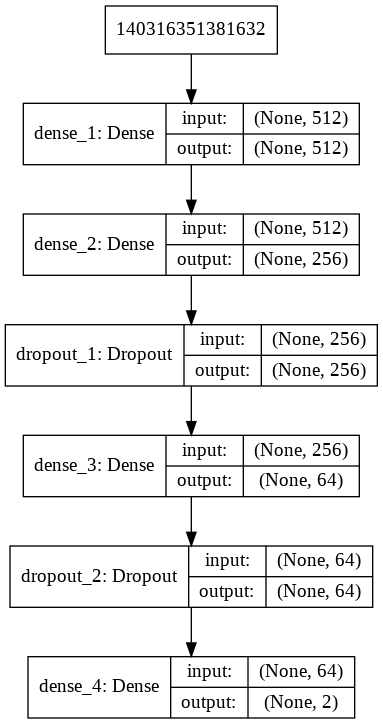

In [140]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image('model.png')

**The model is trained on the training dataset with a validation split of 10%. It is trained for 5 epochs and a batch size of 500 so that it is memoery efficient**

In [24]:
model.fit(train_embeddings, y_train_cat, validation_split=0.1, epochs=5, batch_size=500)

Instructions for updating:
Use tf.cast instead.


W0324 17:59:21.349877 140318966671232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 7650 samples, validate on 850 samples
Epoch 1/5
7650/7650 [==============================] - 13s 2ms/step - loss: 0.4915 - acc: 0.7528 - val_loss: 0.4090 - val_acc: 0.6553
Epoch 2/5
7650/7650 [==============================] - 0s 16us/step - loss: 0.3123 - acc: 0.8616 - val_loss: 0.3106 - val_acc: 0.8847
Epoch 3/5
7650/7650 [==============================] - 0s 15us/step - loss: 0.2715 - acc: 0.8871 - val_loss: 0.2557 - val_acc: 0.9012
Epoch 4/5
7650/7650 [==============================] - 0s 17us/step - loss: 0.2461 - acc: 0.8963 - val_loss: 0.2485 - val_acc: 0.9012
Epoch 5/5
7650/7650 [==============================] - 0s 16us/step - loss: 0.2295 - acc: 0.9068 - val_loss: 0.2344 - val_acc: 0.9094


**Getting the USE for test data**




In [25]:
test_embeddings = get_embeddings(x_test.values)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 17:59:56.201685 140318966671232 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [26]:
model.evaluate(test_embeddings, y_test_cat)

592/592 [==============================] - 0s 71us/step


[0.3948657689867793, 0.8445945945945946]

**Predict labels for test embeddings using model.predict**

*The predicted labels are in one hot encoded format which are later converted using np.argmax*

In [0]:
predicts = model.predict(test_embeddings)

In [0]:
y_pred = np.argmax(predicts, axis=1)

In [33]:
y_test.shape, y_pred.shape

((592,), (592,))

**This is a simple class to evalute different models that we will be using in this notebook**
It plots the confusion matrix, accuracy and a classification report

In [0]:
class evaluateModel():
  def __init__(self, y_true, y_pred):
    self.y_true = y_true
    self.y_pred = y_pred
  
  def plot_cm(self):
    cm = confusion_matrix(self.y_true, self.y_pred)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
  
  def get_accuracy(self):
    print(accuracy_score(self.y_true, self.y_pred))
  
  def get_report(self):
    print(classification_report(self.y_true, self.y_pred))

In [0]:
eval_model = evaluateModel(y_test, y_pred)

**As we can see from the report, the Label 1 has a higher precision of 0.88 which is quite good.**

In [52]:
eval_model.get_report()

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       296
           1       0.88      0.79      0.84       296

   micro avg       0.84      0.84      0.84       592
   macro avg       0.85      0.84      0.84       592
weighted avg       0.85      0.84      0.84       592



**The model achhieves a good accuracy of 84% on the test dataset**

In [53]:
eval_model.get_accuracy()

0.8445945945945946


**The confusion matrix helps us in visualising the predictions of the model**

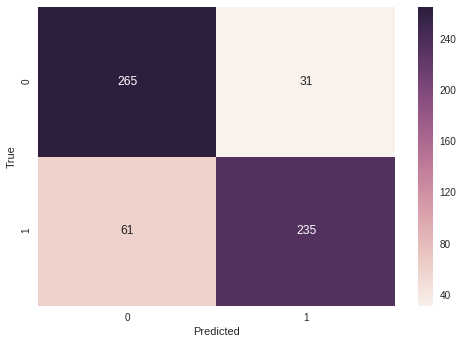

In [54]:
eval_model.plot_cm()

### One might wonder how does the model perform if the text is preprocessed a bit.

USE is pretty powerful because it gave us good results without preprocessing the data

In [0]:
!pip install contractions

In [0]:
import spacy
import re

import contractions
import unicodedata


nlp = spacy.load('en', parse = True, tag=True, entity=True)


In [0]:
def remove_accented_chars(text):
  '''
  This function converts all the text in unicode.
  '''
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text


def expand(text):
  '''
  This function expands all the contractions present in the text. 
  For example - Can't -> Cannot
  '''
  return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
  '''
  This function removes special characters from the text
  '''
  pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)
  return text
  
def lemmatize_text(text):
  '''
  This function lemmatizes text. lemmatization is a powerful
  process which converts words into their corresponding root word.
  '''
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

In [0]:
import tqdm

def normalize_text(text):
  '''
  This function performs all the preprocessing actions on the textual data.
  '''
  normalized_corpus = []
  
  for doc in tqdm.tqdm(text):
    doc = remove_accented_chars(doc)
    doc = expand(doc)
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    doc = lemmatize_text(doc)
    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    doc = special_char_pattern.sub(" \\1 ", doc)
    doc = remove_special_characters(doc, remove_digits=True)
    
    doc = re.sub(' +', ' ', doc)

    normalized_corpus.append(doc)
    
  return normalized_corpus

**Repeating same process as before for the normalized/preprocessed data**

In [76]:
x_train_normalized = normalize_text(x_train)
x_test_normalized = normalize_text(x_test)

100%|██████████| 592/592 [00:12<00:00, 46.29it/s]


In [0]:
normalized_train_splits = np.array_split(x_train_normalized, 17)
normalized_train_splits = np.array(normalized_train_splits)

In [0]:
normalized_train_embeddings = []

for split in tqdm.tqdm(normalized_train_splits):
  embedding = get_embeddings(split)
  normalized_train_embeddings.append(embedding)

In [93]:
normalized_train_embeddings = np.array(normalized_train_embeddings)
normalized_train_embeddings = normalized_train_embeddings.reshape(-1, train_embeddings.shape[-1])
normalized_train_embeddings.shape

(8500, 512)

In [95]:
normalized_test_embeddings = get_embeddings(x_test_normalized)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:44:10.929378 140318966671232 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
normalized_model = create_model()

In [97]:
normalized_model.fit(normalized_train_embeddings, y_train_cat, epochs=5, validation_split=.1, batch_size=500)

Train on 7650 samples, validate on 850 samples
Epoch 1/5
7650/7650 [==============================] - 37s 5ms/step - loss: 0.5278 - acc: 0.7493 - val_loss: 0.4703 - val_acc: 0.6553
Epoch 2/5
7650/7650 [==============================] - 0s 16us/step - loss: 0.3646 - acc: 0.8005 - val_loss: 0.3822 - val_acc: 0.8659
Epoch 3/5
7650/7650 [==============================] - 0s 17us/step - loss: 0.3214 - acc: 0.8729 - val_loss: 0.3221 - val_acc: 0.8824
Epoch 4/5
7650/7650 [==============================] - 0s 16us/step - loss: 0.2883 - acc: 0.8805 - val_loss: 0.2857 - val_acc: 0.8929
Epoch 5/5
7650/7650 [==============================] - 0s 16us/step - loss: 0.2716 - acc: 0.8831 - val_loss: 0.2804 - val_acc: 0.8906


In [99]:
normalized_model.evaluate(normalized_test_embeddings, y_test_cat)

592/592 [==============================] - 0s 81us/step


[0.4489438437126778, 0.8108108108108109]

In [0]:
normalized_predicts = normalized_model.predict(normalized_test_embeddings)

In [0]:
y_normalized_predicts = np.argmax(normalized_predicts, axis=1)

**The model gives a worse accuracy score for preprocessed data which is quite strange**

This may be a testament to USE's robustness and how powerful it is for out of the box transfer learning on NLP tasks

In [0]:
eval_new_model = evaluateModel(y_test, y_normalized_predicts)

In [107]:
eval_new_model.get_accuracy()

0.8108108108108109


In [108]:
eval_new_model.get_report()

              precision    recall  f1-score   support

           0       0.78      0.88      0.82       296
           1       0.86      0.75      0.80       296

   micro avg       0.81      0.81      0.81       592
   macro avg       0.82      0.81      0.81       592
weighted avg       0.82      0.81      0.81       592



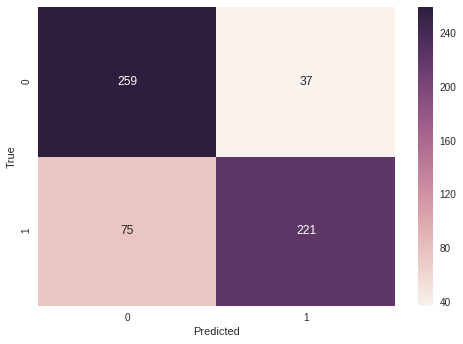

In [109]:
eval_new_model.plot_cm()

#### Just checking another classifier to get an idea of different performances

The XGBoost classifier also performs worse than our first model


In [115]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100)
xgb.fit(train_embeddings, y_train)

xgb_preds = xgb.predict(test_embeddings)

accuracy_score(y_test, xgb_preds)

0.7871621621621622

***Getting USE embeddings for evaluation data***

In [119]:
eval_embeddings = get_embeddings(x_eval.values)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0324 18:58:53.219254 140318966671232 saver.py:1483] Saver not created because there are no variables in the graph to restore


**Since the first model performs the best with a 84% accuracy, we'll go with that model for making final submissions**

In [0]:
eval_predicts = model.predict(eval_embeddings)

In [0]:
eval_preds = np.argmax(eval_predicts, axis=1)

In [0]:
evaluation[2] = eval_preds

The number of Label 1 predictions is quite less which is a bit strange.

In [133]:
evaluation[2].value_counts()

0    746
1     87
Name: 2, dtype: int64

**Converting predicted dataframe into csv and the required format**

In [0]:
evaluation.to_csv('anmol_goel.csv')